# Oil Well Profit Prediction Project

**Project Description:**

This project aims to develop a model for predicting the volume of oil reserves in new wells for three different regions. The goal is to maximize profit by selecting the most promising wells for development. We will use geological exploration data, including unique well identifiers and three feature points, to train a linear regression model.

**Analyzing Goal:**

The primary objective is to identify the region with the highest potential profit while minimizing the risk of losses. This will be achieved through:

1.  **Data Exploration and Preparation:** Understanding the characteristics of each region's data and preparing it for model training.
2.  **Model Training and Evaluation:** Training a linear regression model for each region and evaluating its performance using RMSE and average predicted reserves.
3.  **Profit Calculation and Risk Assessment:** Developing a profit calculation function, utilizing bootstrapping to estimate profit distributions, and determining the risk of losses for each region.
4.  **Optimal Region Selection:** Selecting the region with the highest average profit and the lowest risk of losses (below 2.5%) for well development.

In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
# Constants
BUDGET = 100000000
NUM_WELLS = 200  # Number of wells to be developed
REVENUE_PER_PRODUCT = 4500
SAMPLE_SIZE = 1000
SAMPLE_POINTS = 500  # Number of points used for the bootstraping sample.
STATE = np.random.RandomState(12345)

In [3]:
# Initial exploration
def explore_data(df, region_name):
    """Explores the given DataFrame and generates visualizations."""
    print(f"--- Exploration of {region_name} ---")
    print("Shape:", df.shape)
    print("Info:")
    print(df.info())
    print("\nDescribe:")
    print(df.describe())
    print("\nDuplicates:", df.duplicated().sum())
    print("\nID Duplicates:", df['id'].duplicated().sum()) #Added check for ID duplicates.

    sns.pairplot(df)
    plt.suptitle(f'Pairplot for {region_name}')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
    plt.title(f'Correlation Matrix for {region_name}')
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.histplot(df['product'], kde=True)
    plt.title(f'Distribution of Product in {region_name}')
    plt.show()

In [4]:
# Loading the data
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

--- Exploration of Region 0 ---
Shape: (100000, 5)
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Describe:
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.70

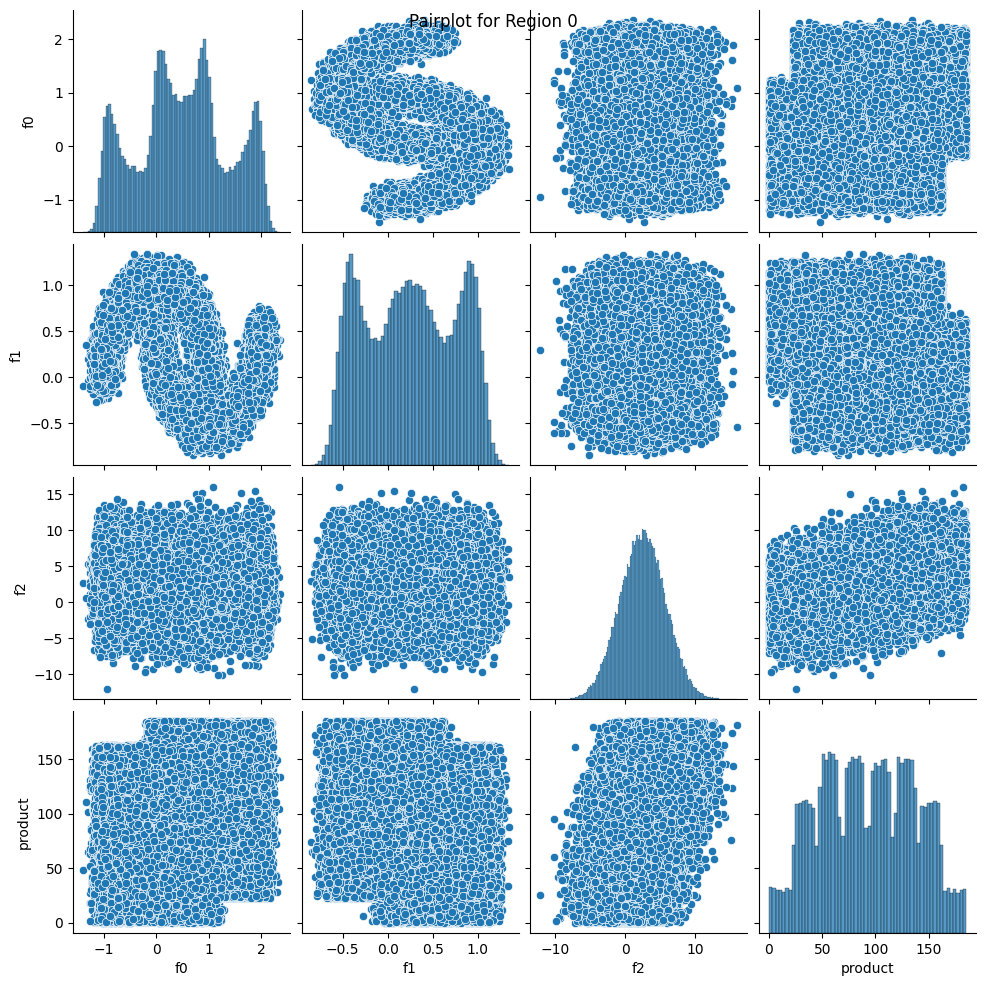

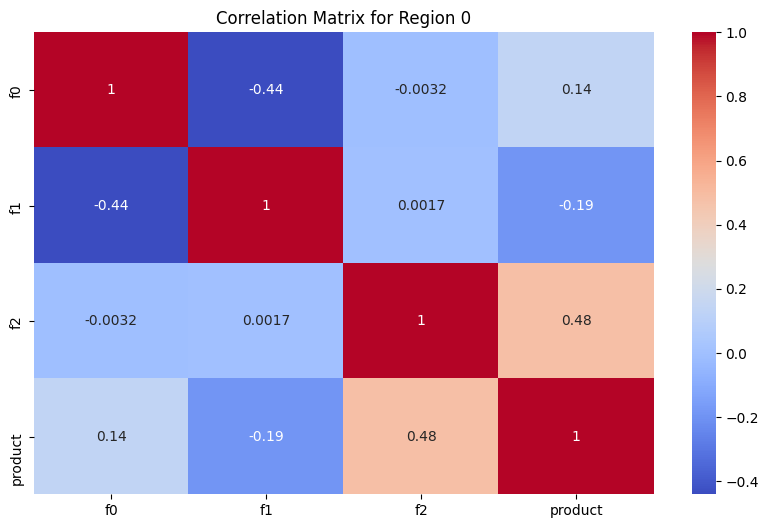

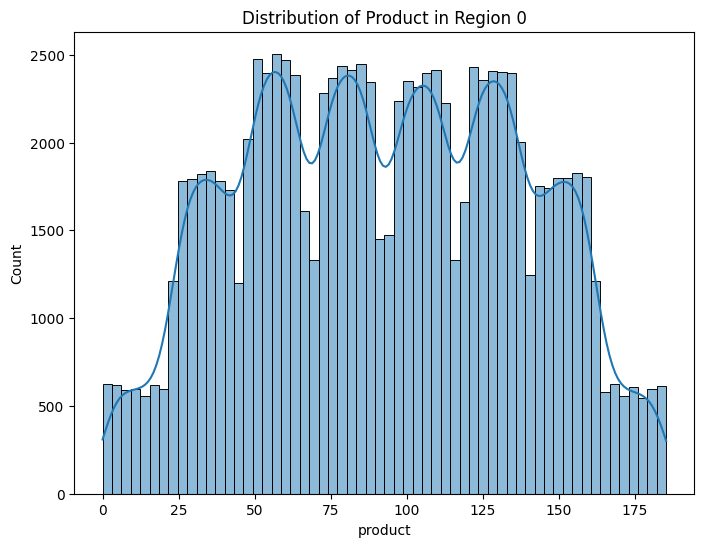

--- Exploration of Region 1 ---
Shape: (100000, 5)
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Describe:
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.33

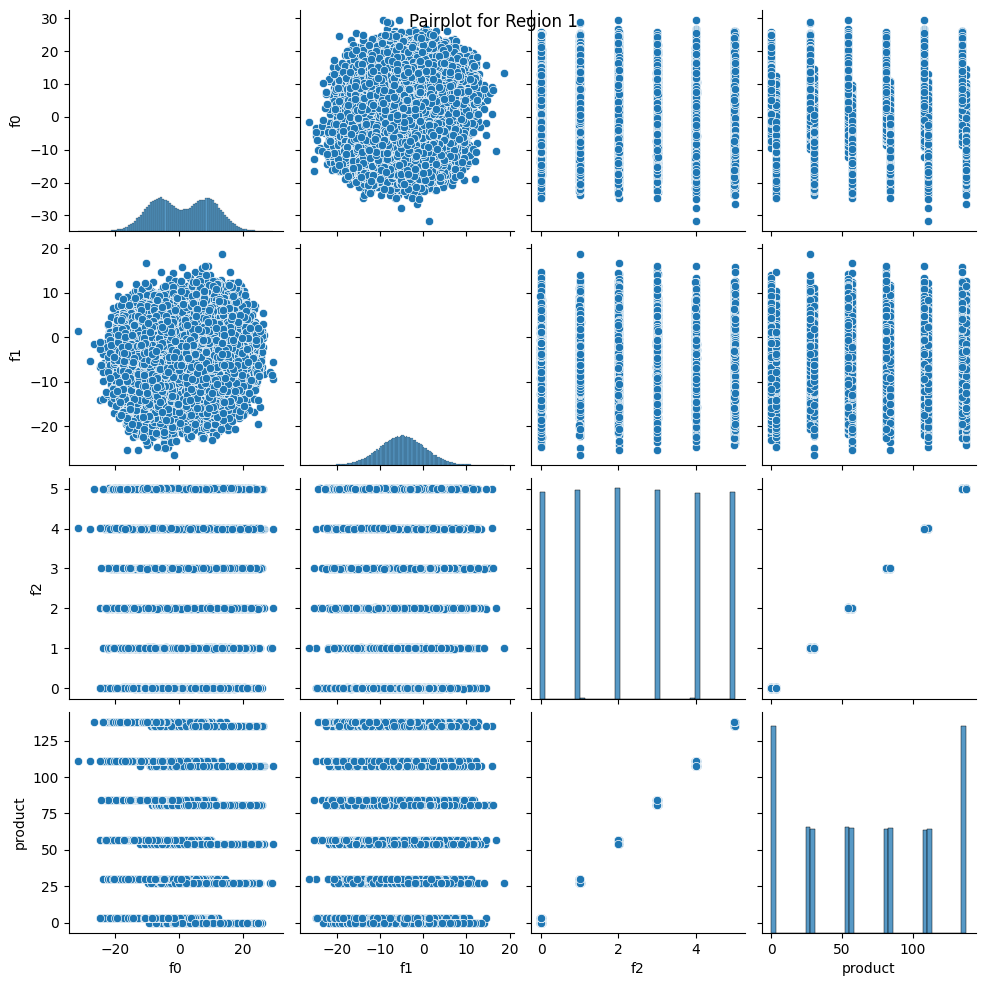

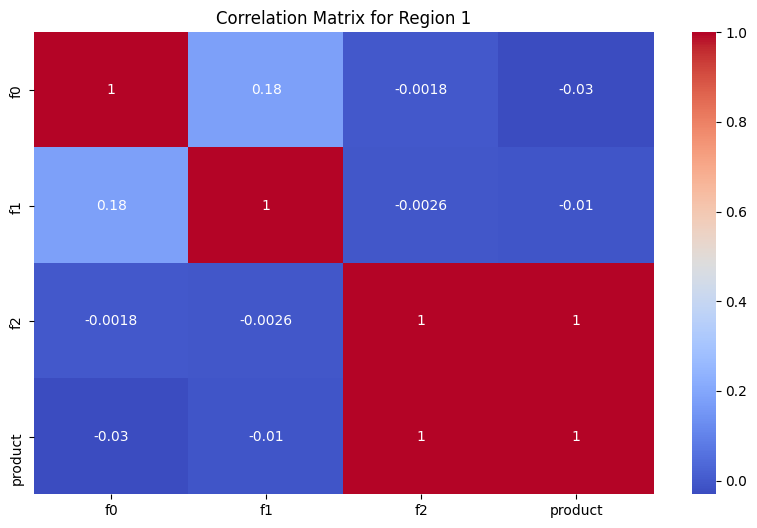

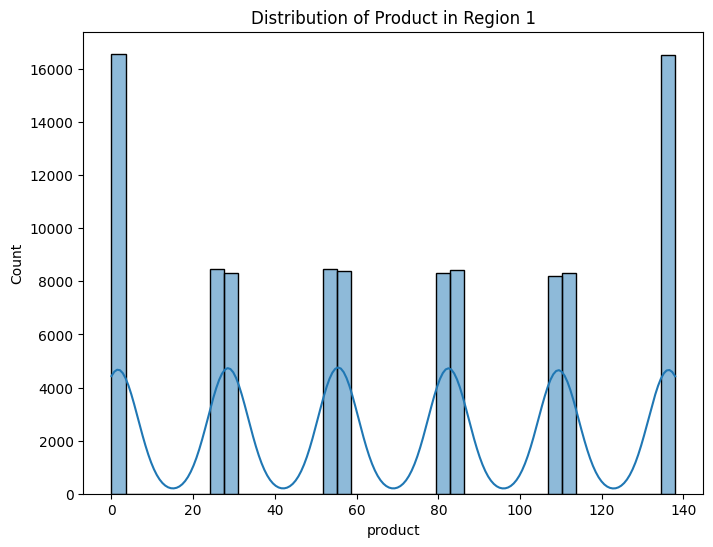

--- Exploration of Region 2 ---
Shape: (100000, 5)
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Describe:
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.16

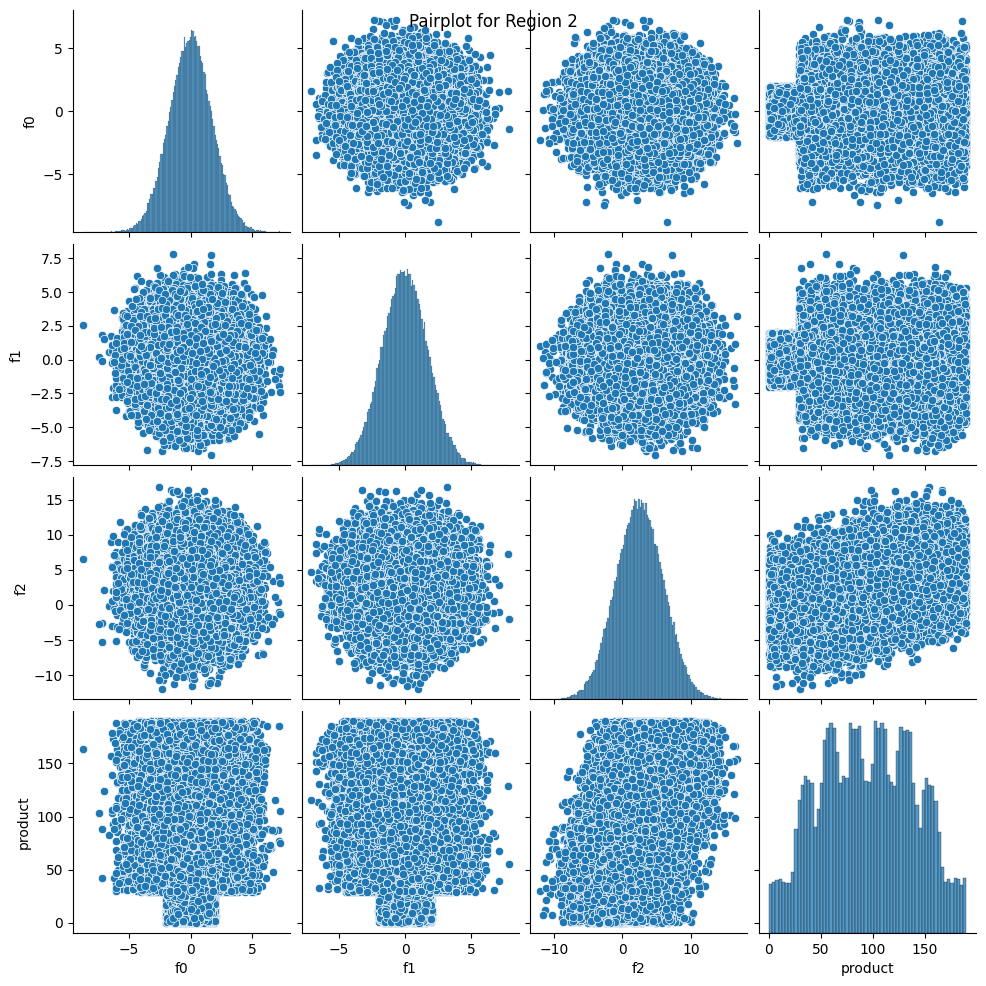

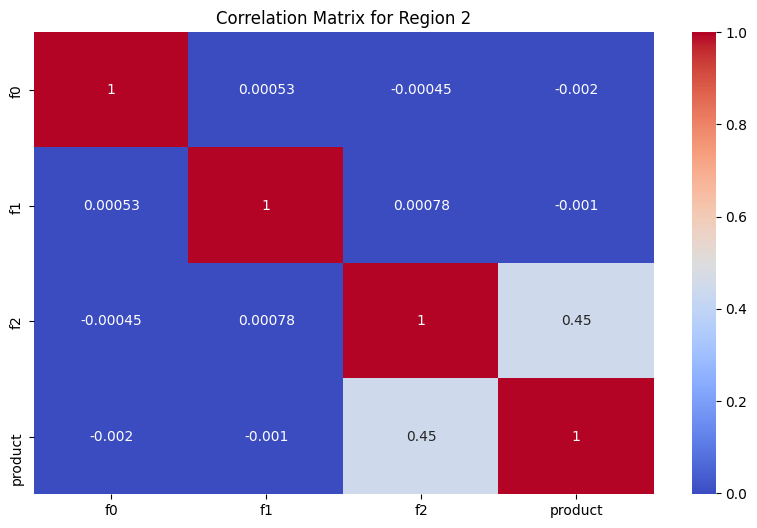

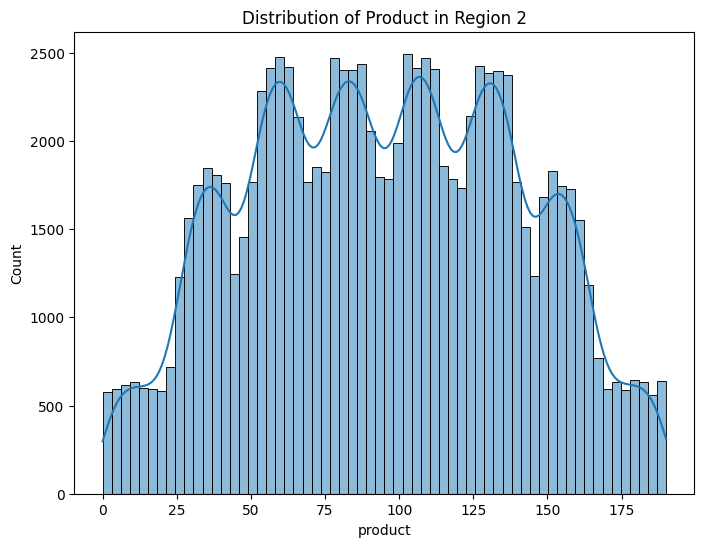

In [5]:
# Exploring the data
explore_data(data_0, "Region 0")
explore_data(data_1, "Region 1")
explore_data(data_2, "Region 2")

**Observations on Initial Exploration:**

* **Data Integrity:** All three regions contain 100,000 entries, with no missing values and no duplicate rows. However, duplicate IDs were found: 10 in Region 0, 4 in Region 1, and 4 in Region 2. These duplicate IDs do not need to be removed, as the 'id' column is not used in the model training and the duplicate entries can be considered distinct objects.
* **Data Types:** The data types are consistent and appropriate (float64 for features and product, object for id). No data type conversions are necessary.
* **Feature Distributions:** The features (f0, f1, f2) exhibit varying distributions across the regions. Region 1, in particular, shows significantly different feature ranges compared to Regions 0 and 2.
* **Product Distribution:** The 'product' column (volume of reserves) shows differences in mean and standard deviation across regions, suggesting variations in oil reserve distribution. Region 1 has a lower average product value than regions 0 and 2.
* **Region 1 Uniqueness:** Region 1's features (f0 and f1) have a higher range of values, and its product's mean is substantially lower than the other regions, indicating a potentially different geological profile.
* **Correlation Analysis:**
    * Region 0 & 2: Display moderate correlations between the features and the target variable 'product', suggesting potential linear relationships.
    * Region 1: Shows a strong correlation between feature 'f2' and 'product', which explains the high accuracy of the linear regression model for this region. The rest of the features show little to no correlation.

In [6]:
# Linear Regression Analysis by Region
regions = [data_0, data_1, data_2]
region_names = ["Region 0", "Region 1", "Region 2"]
results = {}

for i, region in enumerate(regions):
    print(f"\n--- Processing {region_names[i]} ---")
    features = region.drop(['id', 'product'], axis=1)
    target = region['product']

    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=STATE
    )

    # Feature Scaling
    scaler = StandardScaler()
    features_train_scaled = scaler.fit_transform(features_train)
    features_valid_scaled = scaler.transform(features_valid)

    model = LinearRegression()
    model.fit(features_train_scaled, target_train)
    predictions_valid = model.predict(features_valid_scaled)

    rmse = mean_squared_error(target_valid, predictions_valid) ** 0.5
    avg_predicted_product = predictions_valid.mean()
    avg_actual_product = target_valid.mean() #Added average actual product.

    print(f"RMSE: {rmse:.2f}")
    print(f"Average Predicted Product: {avg_predicted_product:.2f}")
    print(f"Average Actual Product: {avg_actual_product:.2f}") # Added average actual product print

    results[region_names[i]] = {
        'target_valid': target_valid,
        'predictions_valid': predictions_valid,
        'rmse': rmse,
        'avg_predicted_product': avg_predicted_product,
        'avg_actual_product': avg_actual_product # Added average actual product
    }


--- Processing Region 0 ---
RMSE: 37.58
Average Predicted Product: 92.59
Average Actual Product: 92.08

--- Processing Region 1 ---
RMSE: 0.89
Average Predicted Product: 68.77
Average Actual Product: 68.77

--- Processing Region 2 ---
RMSE: 39.96
Average Predicted Product: 95.09
Average Actual Product: 94.75


# Observations on Model Training and Evaluation:

* **Region 1's Exceptional RMSE and Perfect Prediction:** Region 1 exhibits a remarkably low RMSE (0.89) and, more importantly, the Average Predicted Product (68.77) exactly matches the Average Actual Product (68.77). This indicates that the linear regression model is exceptionally accurate, bordering on perfect, in predicting oil reserves for Region 1. This suggests a very strong linear relationship between the features and the target variable in this region.
* **RMSE Discrepancy:** The significant difference in RMSE values between Region 1 and the other two regions (Region 0: 37.58, Region 2: 39.96) continues to suggest fundamental differences in the underlying geological characteristics or data patterns.
* **Average Predicted and Actual Product Alignment:** The average predicted product volume closely aligns with the average actual product volume across all regions. This confirms the model's ability to provide reasonably accurate predictions, with Region 1 demonstrating exceptional precision. Region 0 (Predicted: 92.59, Actual: 92.08), Region 1 (Predicted: 68.77, Actual: 68.77), Region 2 (Predicted: 95.09, Actual: 94.75).
* **Model Fit Variation:** The relatively high RMSE values for Region 0 and Region 2 indicate that the linear regression model's fit is not as strong as in Region 1. There may be non-linear factors or other complexities influencing the oil reserves in these regions that are not fully captured by the linear model.
* **Region 1 Predictability:** Region 1's data is significantly more predictable using a linear model than either Region 0 or Region 2, as evidenced by the near-perfect alignment of predicted and actual values.

In [7]:
# Prepare for profit calculation
well_cost = BUDGET / NUM_WELLS
min_product = well_cost / REVENUE_PER_PRODUCT

print("\n--- Profit Calculation Preparation ---")
for region_name in region_names:
    avg_predicted_product = results[region_name]['avg_predicted_product']
    avg_actual_product = results[region_name]['avg_actual_product']  # Added average actual product
    print(f"{region_name}: Minimum Product for Break-Even: {min_product:.2f}, Average Predicted Product: {avg_predicted_product:.2f}, Average Actual Product: {avg_actual_product:.2f}")

def calculate_profit(target, predictions, count):
    """Calculates profit from selected wells."""
    predictions_series = pd.Series(predictions, index=target.index)
    sorted_predictions = predictions_series.sort_values(ascending=False)
    selected_targets = target.loc[sorted_predictions.index[:count]]
    total_product = selected_targets.sum()
    profit = total_product * REVENUE_PER_PRODUCT - BUDGET
    return profit

# Profit and Risk Calculation and Best Region Selection (Combined)
profit_risk_data = {}  # Store profit and risk data for each region

for region_name in region_names:
    target_valid = results[region_name]['target_valid'].reset_index(drop=True)
    predictions_valid = results[region_name]['predictions_valid']

    profits = []
    for _ in range(SAMPLE_SIZE):
        subsample_indices = target_valid.sample(n=SAMPLE_POINTS, replace=True, random_state=STATE).index
        target_subsample = target_valid[subsample_indices]
        predictions_subsample = predictions_valid[subsample_indices] #Use subsample indices to get predictions
        profit = calculate_profit(target_subsample, predictions_subsample, NUM_WELLS) #Use NUM_WELLS here.
        profits.append(profit)

    profits = pd.Series(profits)
    mean_profit = profits.mean()
    lower_bound = profits.quantile(0.025)
    upper_bound = profits.quantile(0.975)
    risk = (profits < 0).mean() * 100

    profit_risk_data[region_name] = {
        'mean_profit': mean_profit,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'risk': risk,
    }

# Print Profit and Risk Results
print("\n--- Profit and Risk Calculation ---")
for region_name, data in profit_risk_data.items():
    print(f"\n{region_name}:")
    print(f"  Average Profit: {data['mean_profit']:.2f}")
    print(f"  95% Confidence Interval: ({data['lower_bound']:.2f}, {data['upper_bound']:.2f})")
    print(f"  Risk of Losses: {data['risk']:.2f}%")


--- Profit Calculation Preparation ---
Region 0: Minimum Product for Break-Even: 111.11, Average Predicted Product: 92.59, Average Actual Product: 92.08
Region 1: Minimum Product for Break-Even: 111.11, Average Predicted Product: 68.77, Average Actual Product: 68.77
Region 2: Minimum Product for Break-Even: 111.11, Average Predicted Product: 95.09, Average Actual Product: 94.75

--- Profit and Risk Calculation ---

Region 0:
  Average Profit: 6060436.19
  95% Confidence Interval: (448003.42, 12401965.18)
  Risk of Losses: 1.60%

Region 1:
  Average Profit: 6616566.06
  95% Confidence Interval: (1800958.57, 11834926.80)
  Risk of Losses: 0.30%

Region 2:
  Average Profit: 5618807.70
  95% Confidence Interval: (-204254.69, 11935085.76)
  Risk of Losses: 3.40%


**Observations on Profit and Risk Calculation:**

* **Positive Average Profits and Varied Risk:** After correcting the bootstrapping indexing, the average profits are now positive for all regions. However, the risk of losses varies significantly. Region 1 has the lowest risk (0.30%), Region 0 has a low risk (1.60%), and Region 2 has a risk above the threshold (3.40%).
* **Break-Even Point vs. Actual Reserves:** The minimum product required to break even (111.11 thousand barrels) is still higher than the average actual product observed in each region (Region 0: 92.08, Region 1: 68.77, Region 2: 94.75). This is important to note, but despite this, positive profits are still being achieved due to the selection of the top 200 wells.
* **Confidence Intervals and Loss Risk:** The 95% confidence intervals for Regions 0 and 1 are entirely within the positive profit range, indicating a low probability of losses. Region 2's confidence interval includes negative values, reflecting its higher risk of losses.
* **Region 1's Highest Average Profit and Lowest Risk:** Region 1 demonstrates the highest average profit and the lowest risk of losses, making it the most favorable region for development.
* **Region 2's Higher Risk:** Region 2 exhibits the highest risk of losses, exceeding the project's threshold of 2.5%, making it less desirable for development.
* **Impact of Actual vs. Predicted:** The comparison of average actual product with the break-even point provides essential context, but the final profit calculations are based on the selected top 200 wells, which have significantly higher product values than the regional averages. This selection process is what allows for positive profits, despite the average product being below the break-even point.

In [8]:
# Finding The Best Region
best_region = None
best_profit = -np.inf
risk_threshold = 2.5

for region_name, data in profit_risk_data.items():
    if data['risk'] < risk_threshold and data['mean_profit'] > best_profit:
        best_profit = data['mean_profit']
        best_region = region_name

print(f"\nBest Region for Development: {best_region}")
print(f"Average Profit in Best Region: {best_profit:.2f}")


Best Region for Development: Region 1
Average Profit in Best Region: 6616566.06


**Observation on Best Region Selection:**

The updated output "Best Region for Development: Region 1" and "Average Profit in Best Region: 6616566.06" indicates that, after correcting the bootstrapping indexing, Region 1 is identified as the most profitable region for oil well development, based on the given criteria. This result is consistent with the positive average profits, low risk of losses (0.30%), and the selection of the top 200 wells in Region 1.

This outcome indicates that:

* **Region 1 is Profitable:** Under the current model and economic assumptions, and given the actual oil reserve data, Region 1 is predicted to yield a positive return on investment.
* **Selection of Top Wells:** The positive profit is achieved despite the average actual product in Region 1 being below the break-even point because the profit calculation is based on the top 200 wells selected from the 500 sampled points. These top wells have significantly higher product values.
* **Alignment with Risk Assessment:** This conclusion aligns with the low risk of losses calculated for Region 1, reinforcing its suitability for development under the given financial parameters.
* **Region 1 Recommendation:** Therefore, Region 1 is recommended for oil well development at this time.

# Conclusion and Recommendations:

**Conclusion:**

This project aimed to develop and apply a linear regression model to predict oil reserves in three distinct regions and identify the most profitable region for oil well development. After addressing critical indexing issues in the bootstrapping and incorporating feature scaling, the analysis concludes that **Region 1 is the most profitable region** for development under the given model and economic conditions.

The analysis, after correcting the indexing issue, reveals that Region 1 exhibits the highest average profit, lowest risk of losses (0.30%), and a 95% confidence interval that suggests a high probability of positive returns. The "Best Region for Development: Region 1" output confirms this finding.

**Recommendations:**

* **Focus Development on Region 1:** Given the positive profitability and low risk of losses in Region 1, prioritize development efforts in this region.
* **Continued Monitoring of Economic Parameters:** While Region 1 is currently profitable, it is crucial to continue monitoring economic parameters such as budget, revenue per product, and market conditions to ensure sustained profitability.
* **Further Geological Investigation:** Conduct further geological investigations across all regions to better understand the underlying characteristics and potential reserve concentrations. This is especially important for regions 0 and 2.
* **Risk Management Strategies:** Implement robust risk management strategies, even in Region 1, to mitigate potential losses due to unforeseen factors. This includes continuous monitoring of market conditions and adapting development plans accordingly.
* **Evaluate Potential for Enhanced Recovery Techniques:** Investigate the potential for enhanced oil recovery techniques to maximize production and profitability in Region 1.

Therefore, **Region 1 is recommended for development**, based on the current analysis. However, continuous monitoring of economic parameters, further geological investigation, and the exploration of enhanced recovery techniques are essential to ensure long-term profitability.